In [36]:
import trimesh
import numpy as np

model = trimesh.load('./obj/model.stl')
samples, face_indexes = trimesh.sample.sample_surface_even(model, 300)

In [37]:
normals = []

for i in range(len(samples)):
    sample = samples[i]  # 표면 위의 샘플링된 점
    face_index = face_indexes[i]  # 해당 점이 속한 삼각형 면의 인덱스

    # 삼각형 면의 노말 벡터 가져오기
    normal = model.face_normals[face_index]

    # 샘플 점에서의 노말 벡터 추가
    normals.append(normal)

In [38]:
# samples

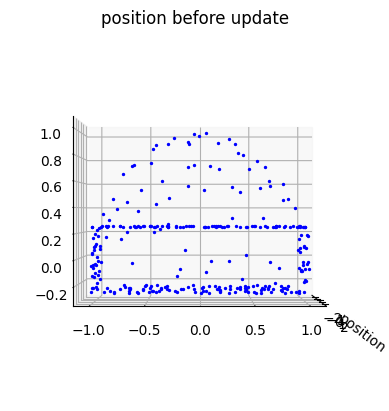

In [39]:
import matplotlib.pyplot as plt

# nums의 최소값과 최대값 구하기
min_num = np.min(samples)
max_num = np.max(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(samples)):

    # 샘플링된 점 그리기
    ax.scatter(samples[i][0], samples[i][1], samples[i][2], marker= 'o', s=2, color='b')

ax.view_init(elev=0, azim=0)

plt.title('position before update')
plt.xlabel('position')
plt.show()

In [ ]:
from scipy.stats import norm

count = 0

while count < 100:
    
    # dens = []
    vec = []
    
    for i in range(len(samples)):
        # sum_pdf = 0
        vec_total = 0
        # 여기에 가우시안 넣어야 될듯
        for num2 in samples:
            if not np.array_equal(samples[i], num2):
                # gaussian 커널로 점들간 거리에 따라 확률추정
                # 이게 벡터의 크기
                distance = np.linalg.norm(samples[i] - num2)
                p = norm.pdf(distance, 0, 0.1)
                # 점 num에서 확률추정
                # sum_pdf += p
                vec_total += p * (samples[i]-num2) /distance
                
                vec_total += p * np.subtract(samples[i] - num2, np.dot(samples[i] - num2, normals[i]) * normals[i])
                # tangent = np.subtract(v1, np.dot(v1, normals[i]) * normals[i])
                
        # dens.append(sum_pdf / (len(samples)-1))
        vec.append(0.01 * vec_total)
    
    # dens /= np.sum(dens)
    samples += vec
    count += 1

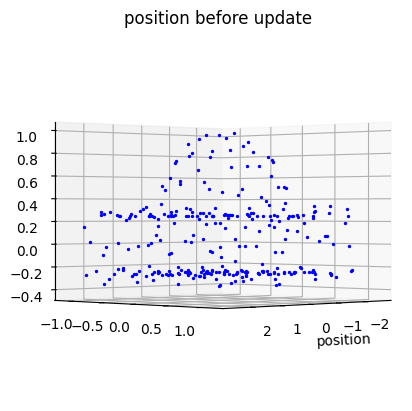

In [26]:
import matplotlib.pyplot as plt

# nums의 최소값과 최대값 구하기
min_num = np.min(samples)
max_num = np.max(samples)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(samples)):

    # 샘플링된 점 그리기
    ax.scatter(samples[i][0], samples[i][1], samples[i][2], marker= 'o', s=2, color='b')

ax.view_init(elev=0, azim= 45)

plt.title('position before update')
plt.xlabel('position')
plt.show()